In [3]:
"""
对抗生成网络实现基于mnist数据集的实现
"""
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./mnist/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/train-labels-idx1-ubyte.gz
Extracting ./mnist/t10k-images-idx3-ubyte.gz
Extracting ./mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


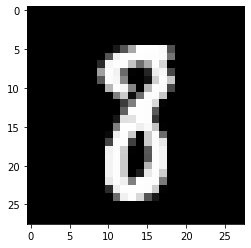

In [6]:
img = mnist.train.images[50]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

# 模型构建
### inputs 输入
### 生成器搭建
### 判别器搭建
### 优化器和损失函数定义

In [16]:
def get_inputs(real_size, noise_size):
    """
    真实图像的tensor和噪声图像tensor
    """
    real_img = tf.placeholder(tf.float32, [None, real_size], name='real_img')
    noise_img = tf.placeholder(tf.float32, [None, noise_size], name='noise_img')
    
    return real_img, noise_img

In [14]:
def get_generator(noise_img, n_units, out_dim, reuse=False, alpha=0.01):
    """
    生成器网络构建
    """
    with tf.variable_scope('generator', reuse=reuse):
        ##隐藏层
        hidden1 = tf.layers.dense(noise_img, n_units)
        
        ##leaky Relu激活函数
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        
        ##dropout
        hidden1 = tf.layers.dropout(hidden1, rate=0.2)
        
        ##logits
        logits = tf.layers.dense(hidden1, out_dim)
        outputs = tf.tanh(logits)
        
        return logits, outputs

### 构建判别器

In [10]:
def get_discriminator(img, n_units, reuse=False, alpha=0.01):
    """
    构建判别器网络
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        ## 隐藏层
        hidden1 = tf.layers.dense(img, n_units)
        hidden1 = tf.maximum(hidden1 * alpha, hidden1)
        
        ##logits
        logits = tf.layers.dense(hidden1, 1)
        outputs = tf.sigmoid(logits)
        return logits, outputs

In [25]:
##定义超参数
img_size = mnist.train.images[0].shape[0]

##传入给生成器的噪声
noise_size = 100

##生成器隐藏层单元数
g_units = 128

d_units = 128
##leaky relu参数
alpha = 0.01

learning_rate= 0.001

#label smoothing
smooth = 0.1

## 构建计算图

In [26]:
tf.reset_default_graph()

real_img, noise_img = get_inputs(img_size, noise_size)

##generator
g_logits, g_outputs = get_generator(noise_img, g_units, img_size)

##判别器
d_logits_real, d_outputs_real = get_discriminator(real_img, d_units)

d_logits_fake, d_outputs_fake = get_discriminator(g_outputs, d_units, reuse=True)

# loss
### gan需要分别训练两个网络一个生成器网络和一个判别器网络，所以loss需要分开进行计算

In [27]:
##判别器loss
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)) * (1 - smooth))

##识别生成的图片
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))

##总体loss
d_loss = tf.add(d_loss_fake, d_loss_real)

##生成器的loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)) * (1 - smooth))


## 针对两个训练的网络，分别定义优化器

In [28]:
train_vars = tf.trainable_variables()

##生成器中的tensor
g_vars = [var for var in train_vars if var.name.startswith('generator')]

#判别器中的tensor
d_vars = [var for var in train_vars if var.name.startswith('discriminator')]

##optimizer
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)


### 开始训练

In [29]:
import pickle
# batch_size
batch_size = 64
# 训练迭代轮数
epochs = 300
# 抽取样本数
n_sample = 25

# 存储测试样例
samples = []
# 存储loss
losses = []
# 保存生成器变量
saver = tf.train.Saver(var_list = g_vars)
# 开始训练
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for batch_i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, 784))
            # 对图像像素进行scale，这是因为tanh输出的结果介于(-1,1),real和fake图片共享discriminator的参数
            batch_images = batch_images*2 - 1
            
            # generator的输入噪声
            batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={real_img: batch_images, noise_img: batch_noise})
            _ = sess.run(g_train_opt, feed_dict={noise_img: batch_noise})
        
        # 每一轮结束计算loss
        train_loss_d = sess.run(d_loss, 
                                feed_dict = {real_img: batch_images, 
                                             noise_img: batch_noise})
        # real img loss
        train_loss_d_real = sess.run(d_loss_real, 
                                     feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # fake img loss
        train_loss_d_fake = sess.run(d_loss_fake, 
                                    feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # generator loss
        train_loss_g = sess.run(g_loss, 
                                feed_dict = {noise_img: batch_noise})
        
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}(Real: {:.4f} + Fake: {:.4f})...".format(train_loss_d, train_loss_d_real, train_loss_d_fake),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # 记录各类loss值
        losses.append((train_loss_d, train_loss_d_real, train_loss_d_fake, train_loss_g))
        
        # 抽取样本后期进行观察
        sample_noise = np.random.uniform(-1, 1, size=(n_sample, noise_size))
        gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                               feed_dict={noise_img: sample_noise})
        samples.append(gen_samples)
        
        # 存储checkpoints
        saver.save(sess, './checkpoints/generator.ckpt')

# 将sample的生成数据记录下来
with open('train_samples.pkl', 'wb') as f:
    pickle.dump(samples, f)

Epoch 1/300... Discriminator Loss: 0.2682(Real: 0.0690 + Fake: 0.1992)... Generator Loss: 2.5334
Epoch 2/300... Discriminator Loss: 1.3296(Real: 0.3560 + Fake: 0.9736)... Generator Loss: 1.8231
Epoch 3/300... Discriminator Loss: 0.9859(Real: 0.2931 + Fake: 0.6928)... Generator Loss: 1.9047
Epoch 4/300... Discriminator Loss: 2.1568(Real: 1.1064 + Fake: 1.0504)... Generator Loss: 0.5839
Epoch 5/300... Discriminator Loss: 0.6706(Real: 0.2676 + Fake: 0.4030)... Generator Loss: 1.9848
Epoch 6/300... Discriminator Loss: 0.9486(Real: 0.4761 + Fake: 0.4724)... Generator Loss: 1.4548
Epoch 7/300... Discriminator Loss: 2.9249(Real: 1.3742 + Fake: 1.5507)... Generator Loss: 0.6805
Epoch 8/300... Discriminator Loss: 1.2717(Real: 0.6561 + Fake: 0.6156)... Generator Loss: 1.1734
Epoch 9/300... Discriminator Loss: 1.4231(Real: 1.1225 + Fake: 0.3006)... Generator Loss: 1.7845
Epoch 10/300... Discriminator Loss: 0.9680(Real: 0.5275 + Fake: 0.4405)... Generator Loss: 1.1930
Epoch 11/300... Discriminator

Epoch 85/300... Discriminator Loss: 1.0524(Real: 0.6377 + Fake: 0.4148)... Generator Loss: 1.4138
Epoch 86/300... Discriminator Loss: 1.1258(Real: 0.5926 + Fake: 0.5332)... Generator Loss: 1.3584
Epoch 87/300... Discriminator Loss: 1.0446(Real: 0.6047 + Fake: 0.4399)... Generator Loss: 1.4711
Epoch 88/300... Discriminator Loss: 1.0801(Real: 0.4927 + Fake: 0.5874)... Generator Loss: 1.2018
Epoch 89/300... Discriminator Loss: 0.9875(Real: 0.4656 + Fake: 0.5219)... Generator Loss: 1.3430
Epoch 90/300... Discriminator Loss: 0.9284(Real: 0.5365 + Fake: 0.3918)... Generator Loss: 1.3634
Epoch 91/300... Discriminator Loss: 1.0151(Real: 0.6314 + Fake: 0.3836)... Generator Loss: 1.5213
Epoch 92/300... Discriminator Loss: 0.8477(Real: 0.4829 + Fake: 0.3649)... Generator Loss: 1.6835
Epoch 93/300... Discriminator Loss: 0.9963(Real: 0.4609 + Fake: 0.5354)... Generator Loss: 1.1482
Epoch 94/300... Discriminator Loss: 1.1286(Real: 0.5957 + Fake: 0.5329)... Generator Loss: 1.2586
Epoch 95/300... Disc

Epoch 168/300... Discriminator Loss: 0.7616(Real: 0.3985 + Fake: 0.3631)... Generator Loss: 1.5755
Epoch 169/300... Discriminator Loss: 0.8687(Real: 0.3943 + Fake: 0.4743)... Generator Loss: 1.3269
Epoch 170/300... Discriminator Loss: 0.9664(Real: 0.5006 + Fake: 0.4658)... Generator Loss: 1.3321
Epoch 171/300... Discriminator Loss: 1.0277(Real: 0.4797 + Fake: 0.5480)... Generator Loss: 1.3530
Epoch 172/300... Discriminator Loss: 0.9581(Real: 0.5107 + Fake: 0.4474)... Generator Loss: 1.5864
Epoch 173/300... Discriminator Loss: 0.9338(Real: 0.2398 + Fake: 0.6940)... Generator Loss: 1.0306
Epoch 174/300... Discriminator Loss: 0.7299(Real: 0.3341 + Fake: 0.3958)... Generator Loss: 1.5888
Epoch 175/300... Discriminator Loss: 0.8040(Real: 0.3300 + Fake: 0.4740)... Generator Loss: 1.3603
Epoch 176/300... Discriminator Loss: 1.0121(Real: 0.5347 + Fake: 0.4773)... Generator Loss: 1.5260
Epoch 177/300... Discriminator Loss: 0.8906(Real: 0.3808 + Fake: 0.5098)... Generator Loss: 1.2589
Epoch 178/

Epoch 251/300... Discriminator Loss: 0.8645(Real: 0.4735 + Fake: 0.3909)... Generator Loss: 1.6884
Epoch 252/300... Discriminator Loss: 0.6930(Real: 0.3136 + Fake: 0.3794)... Generator Loss: 1.6393
Epoch 253/300... Discriminator Loss: 0.7784(Real: 0.3790 + Fake: 0.3995)... Generator Loss: 1.6939
Epoch 254/300... Discriminator Loss: 0.7239(Real: 0.2980 + Fake: 0.4259)... Generator Loss: 1.5760
Epoch 255/300... Discriminator Loss: 1.0417(Real: 0.3289 + Fake: 0.7128)... Generator Loss: 1.2041
Epoch 256/300... Discriminator Loss: 0.8555(Real: 0.3881 + Fake: 0.4674)... Generator Loss: 1.7255
Epoch 257/300... Discriminator Loss: 0.8671(Real: 0.3555 + Fake: 0.5116)... Generator Loss: 1.4257
Epoch 258/300... Discriminator Loss: 0.8698(Real: 0.4990 + Fake: 0.3708)... Generator Loss: 1.8255
Epoch 259/300... Discriminator Loss: 0.9879(Real: 0.4961 + Fake: 0.4917)... Generator Loss: 1.4574
Epoch 260/300... Discriminator Loss: 0.7822(Real: 0.5181 + Fake: 0.2641)... Generator Loss: 2.0176
Epoch 261/

In [30]:
with open('train_samples.pkl', 'rb') as f:
    samples = pickle.load(f)

In [35]:
def view_samples(epoch, samples):
    """
    epoch：代表第几次迭代的图像
    """
    fig, axes = plt.subplots(figsize=(7, 7), nrows=5, ncols=5, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch][1]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
    return fig, axes

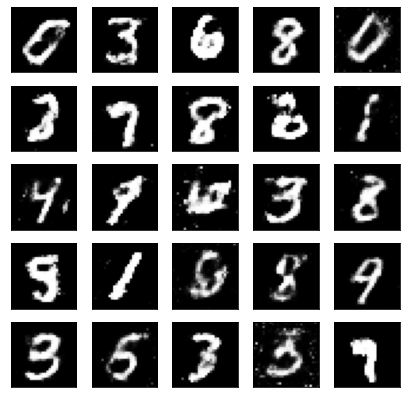

In [38]:
_ = view_samples(-1, samples)

In [39]:
# 指定要查看的轮次
epoch_idx = [0, 5, 10, 20, 40, 60, 80, 100, 150, 250] # 一共300轮，不要越界
show_imgs = []
for i in epoch_idx:
    show_imgs.append(samples[i][1])

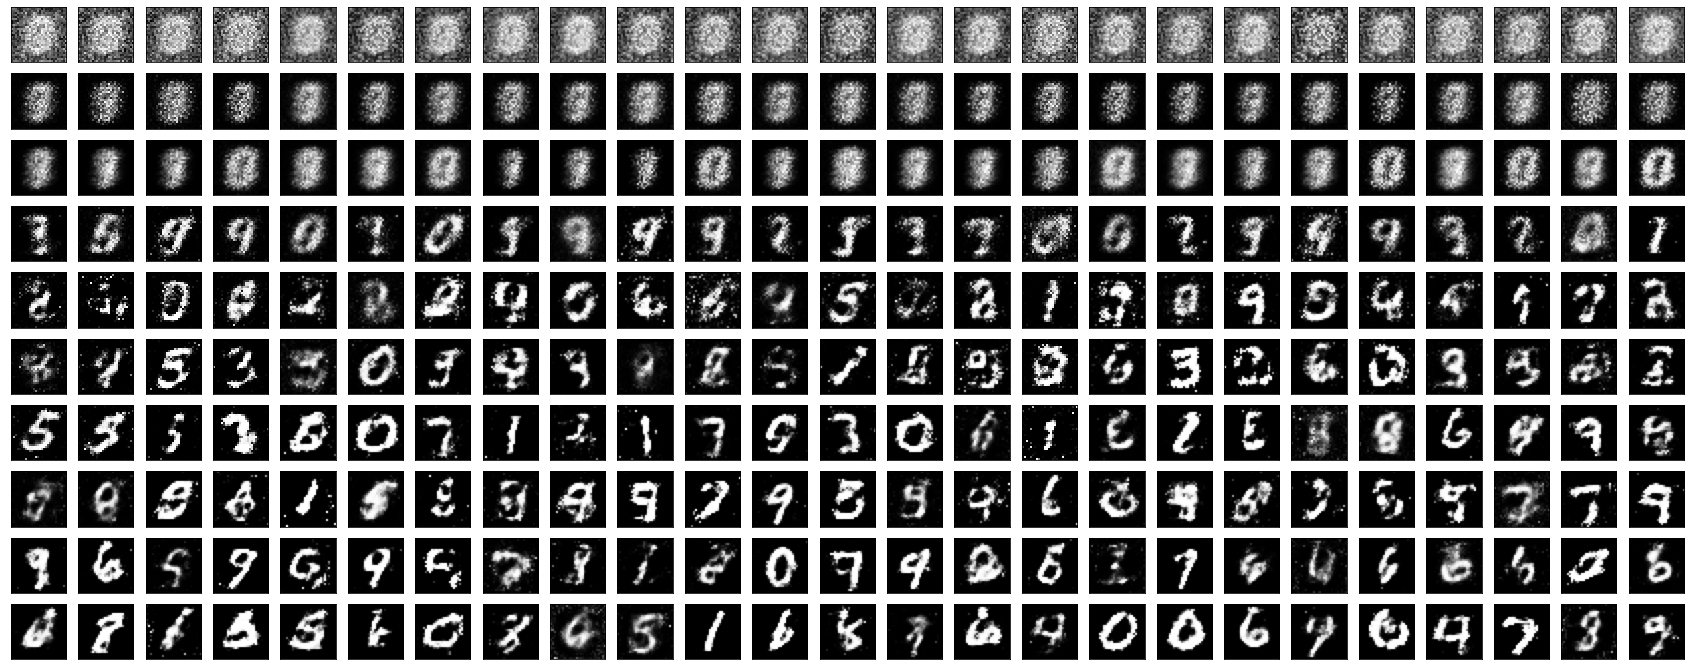

In [40]:
# 指定图片形状
rows, cols = 10, 25
fig, axes = plt.subplots(figsize=(30,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

idx = range(0, epochs, int(epochs/rows))

for sample, ax_row in zip(show_imgs, axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## 生成新的图片 

In [41]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_noise = np.random.uniform(-1, 1, size=(25, noise_size))
    gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True), feed_dict={noise_img: sample_noise})

INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


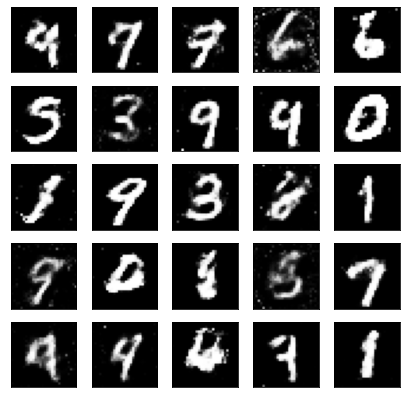

In [42]:
_ = view_samples(0, [gen_samples])